# Load

In [ ]:
import nibabel as nib
import numpy as np

# Load the NIFTI file
nifti_file = "Prob#2.nii\data.NII"
data = nib.load(nifti_file).get_fdata()

# Slices 60-69
slices = data[..., 59:69]

# Adding noise
The Prob#2.nii.gz file has 130 slices each with dimensions of 256×256, perform the required operation on the 60 to 69 slices. Contaminate these cuts with additive Gaussian noise with an average of zero and a deviation from a standard equal to 0.02 of the maximum brightness available in a set of 130 images.

In [ ]:
# Determine the maximum intensity across all images
max_intensity = np.max(data)

# Add Gaussian noise
mean = 0
std_dev = 0.02 * max_intensity
noisy_slices = slices + np.random.normal(mean, std_dev, slices.shape)

# Save or process the noisy slices as needed
# For example, converting them back to a NIFTI file:
noisy_data = np.copy(data)
noisy_data = noisy_slices

# Create a new NIFTI image and save
noisy_nifti = nib.Nifti1Image(noisy_data, affine=nib.load(nifti_file).affine)
output_file = "noisy_data.nii"
nib.save(noisy_nifti, output_file)

print(f"Noisy slices saved as {output_file}")

Noisy slices saved as Prob#2.nii/noisy_data.nii


# Denoising

Perform the denoising process using Total Variation, BM3D, NLM, WNNM methods and calculate and analyze the mean and deviation from the PSNR criterion between the clean image and the denoised image

## Load

In [ ]:
# Load the NIFTI file
nifti_file = "noisy_data.nii"
noisy_slices = nib.load(nifti_file).get_fdata()

## Non-Local Means (NLM)

In [ ]:
from skimage.restoration import denoise_nl_means, estimate_sigma

sigma_est = np.mean(estimate_sigma(noisy_slices, channel_axis=None))
nlm_denoised = denoise_nl_means(
    noisy_slices,
    h=1.15 * sigma_est,
    fast_mode=True,
    patch_size=5,
    patch_distance=6,
    channel_axis=None
)


## BM3D

In [ ]:
from bm3d import bm3d, BM3DProfile

sigma_psd = 0.02
bm3d_denoised = bm3d(noisy_slices, sigma_psd=sigma_psd, profile=BM3DProfile())


## Total Variation (TV)

In [ ]:
from skimage.restoration import denoise_tv_chambolle

tv_denoised = denoise_tv_chambolle(noisy_slices, weight=0.1, channel_axis=None)

## Weighted Nuclear Norm Minimization (WNNM)

In [ ]:
from scipy.linalg import svd

def wnnm(img, patchRadius, delta, c, K, sigma_n,N_threshold):
    # This function applies weighted nuclear norm minimization based denoising to the imput image img
    # Specify the search window
    searchWindowRadius = patchRadius*3

    # Specify the number of iterations for estimating \hat{X}_j
    N_iter = 3

    # Specify the width of padding and pad the noisy image
    pad = searchWindowRadius + patchRadius
    imgPad = np.pad(img, pad_width = pad)
    imgPad = imgPad[..., pad:-pad]

    # Initialize variables to be iterated over
    xhat_iter = img

    for n in range(K):
        # Pad the image for the iteration
        xhat_iter = np.pad(xhat_iter, pad_width = pad)
        xhat_iter = xhat_iter[..., pad:-pad]

        # Regularize the image that is denoised during the iteration
        y_iter = xhat_iter + delta*(imgPad - xhat_iter)

        # Initialize the matrix to keep track of how many times each pixel has been updated
        pixel_contribution_matrix = np.ones_like(imgPad)

        # Identify similar patches and produce the matrix of similar patches
        for j in range(img.shape[0]):
            for i in range(img.shape[1]):
                # Select the central patch
                centerPatch = y_iter[j+searchWindowRadius:j+searchWindowRadius+2*patchRadius,
                                 i+searchWindowRadius:i+searchWindowRadius+2*patchRadius,
                                 :]

                # Initialize the vector of distances between patches
                dists= np.ones(((2*searchWindowRadius+1)**2))
                # Initialize the matrix of patches
                patches = np.zeros(((2*searchWindowRadius+1)**2,(2*patchRadius)**2))
                # Compute distances between patches
                # This is partially vectorized by using indexing to take out patches in a sliding window fashing
                # out of a vertical slice through the search window
                for k in range(2*searchWindowRadius+1):
                    # Take a vertical slice in the search window
                    otherPatch = y_iter[j:j+2*pad,
                                    i+k:i+k+2*patchRadius,
                                    :]

                    # Determine indices corresponding to patches in a window sliding down the search window
                    indexer = np.arange((2*patchRadius)**2)[None, :] + (2*patchRadius)*np.arange(otherPatch.shape[0]-2*patchRadius+1)[:, None]

                    # Set columns to be patches
                    otherPatch = otherPatch.flatten()
                    otherPatch = np.reshape(otherPatch[indexer],(otherPatch[indexer].shape[0],(2*patchRadius)**2))

                    # Compute distance and store the corresponding patches
                    dists[k*(2*searchWindowRadius+1):(k+1)*(2*searchWindowRadius+1)] = (np.sum((centerPatch.reshape(((2*patchRadius)**2))-otherPatch)**2,axis=1)/(2*patchRadius)**2).flatten()
                    patches[k*(2*searchWindowRadius+1):(k+1)*(2*searchWindowRadius+1),:] = otherPatch

                # Select to N_threshold nearest patches and creat a patch matrix
                indcs = np.argsort(dists)
                Yj = (patches[indcs[:N_threshold],:]).transpose()

                # Center the columns
                Yj_means = np.sum(Yj,axis=0)
                Yj_center = Yj - Yj_means

                # First iteration need to estimate singular values of Xj
                U,S,V_T = svd(Yj_center, full_matrices=False)
                sing_val = np.sqrt(np.maximum(S**2-N_threshold*sigma_n**2,0))

                # Calculate the weights and sinfular values of \hat{X}_j iteratively
                for m in range(N_iter):
                    w = c*np.sqrt(N_threshold)/(sing_val+10**(-6))
                    sing_val = np.diag(np.maximum(S-w,0))

                # Compute \hat{X}_j
                Xj_hat_center = U@np.diag(np.maximum(S-w,0))@V_T
                Xj_hat = Xj_hat_center + Yj_means

                # Add the estimate of denoised central patch (first column of \hat{X}_j) to the esmated denoised image clipping it to between 0 and 1
                xhat_iter[j+searchWindowRadius:j+searchWindowRadius+2*patchRadius,
                                 i+searchWindowRadius:i+searchWindowRadius+2*patchRadius,
                                 :] = xhat_iter[j+searchWindowRadius:j+searchWindowRadius+2*patchRadius,
                                 i+searchWindowRadius:i+searchWindowRadius+2*patchRadius,
                                 :] + np.clip(Xj_hat[:,0].reshape((2*patchRadius,2*patchRadius,1)),0,1)

                # Keep track of how many times each pixel has been added to
                pixel_contribution_matrix[j+searchWindowRadius:j+searchWindowRadius+2*patchRadius,
                                 i+searchWindowRadius:i+searchWindowRadius+2*patchRadius,
                                 :] = pixel_contribution_matrix[j+searchWindowRadius:j+searchWindowRadius+2*patchRadius,
                                 i+searchWindowRadius:i+searchWindowRadius+2*patchRadius,
                                 :] + np.ones_like(pixel_contribution_matrix[j+searchWindowRadius:j+searchWindowRadius+2*patchRadius,
                                 i+searchWindowRadius:i+searchWindowRadius+2*patchRadius,:])

        # Remove the padding and average out contributions to pixels from different patches
        xhat_iter = xhat_iter[pad:-pad,
                    pad:-pad,
                   :]/pixel_contribution_matrix[pad:-pad,
                    pad:-pad,
                   :]

    # Produce the final output
    out = xhat_iter
    return out

# Hyperparameters for WNNM
patchRadius = 2           # patch size = 4x4
delta = 0.1
c = 2                     # tuning parameter
K = 1                     # number of iterations (can go higher for more refinement)
sigma_n = 0.02            # noise std dev (same as used for pollution)
N_threshold = 16          # number of similar patches

# Apply WNNM slice-by-slice
wnnm_denoised = np.zeros_like(noisy_slices)

for idx in range(noisy_slices.shape[-1]):
    print(f"Processing slice {idx + 59} with WNNM...")
    slice_input = noisy_slices[..., idx]

    # WNNM expects 3D input (H, W, 1), so we expand dims
    denoised = wnnm(slice_input[..., np.newaxis], patchRadius, delta, c, K, sigma_n, N_threshold)

    # Remove the singleton dimension
    wnnm_denoised[..., idx] = np.squeeze(denoised)


Processing slice 59 with WNNM...
Processing slice 60 with WNNM...
Processing slice 61 with WNNM...
Processing slice 62 with WNNM...
Processing slice 63 with WNNM...
Processing slice 64 with WNNM...
Processing slice 65 with WNNM...
Processing slice 66 with WNNM...
Processing slice 67 with WNNM...
Processing slice 68 with WNNM...


## PSNR & Plot

In [ ]:
def compute_psnr(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = np.max(original)
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

In [ ]:
# Compute PSNR
psnr_wnnm = compute_psnr(slices, wnnm_denoised)
psnr_nlm = compute_psnr(slices, nlm_denoised)
psnr_bm3d = compute_psnr(slices, bm3d_denoised)
psnr_tv = compute_psnr(slices, tv_denoised)
print(f"WNNM PSNR: {psnr_wnnm:.2f} dB")
print(f"NLM PSNR: {psnr_nlm:.2f} dB")
print(f"BM3D PSNR: {psnr_bm3d:.2f} dB")
print(f"TV PSNR: {psnr_tv:.2f} dB")

WNNM PSNR: 16.21 dB
NLM PSNR: 37.32 dB
BM3D PSNR: 33.40 dB
TV PSNR: 33.47 dB


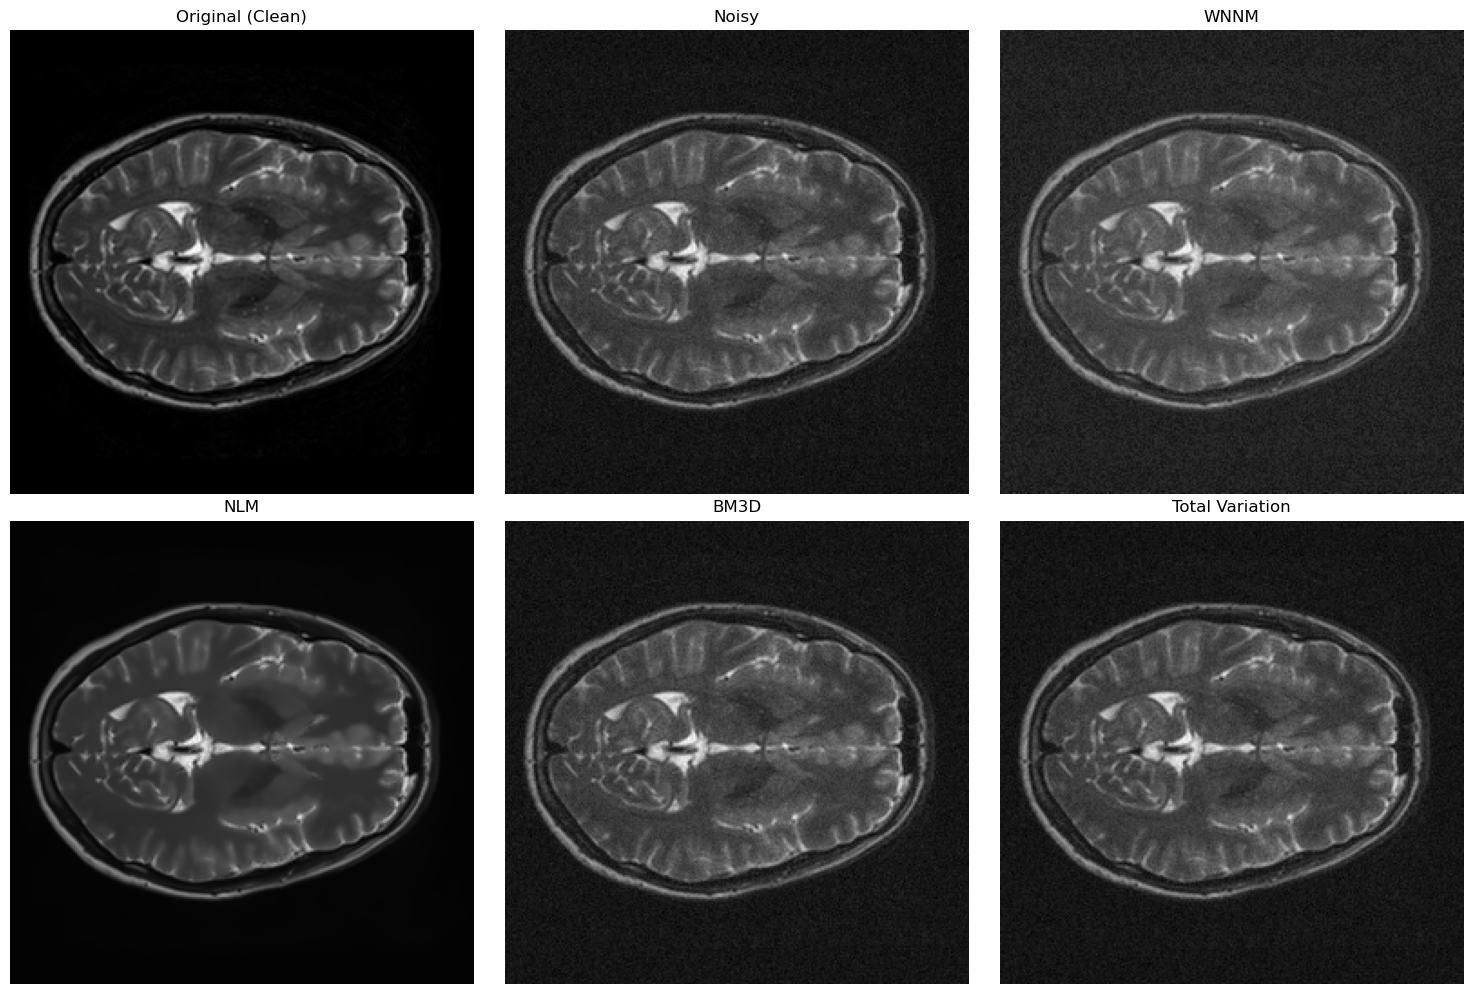

In [ ]:
import matplotlib.pyplot as plt

slice_idx = 5
# Extract precomputed clean, noisy, and WNNM-denoised slices
clean_slice = data[..., slice_idx]
noisy_slice = noisy_slices[..., slice_idx-59]
wnnm_slice = wnnm_denoised[..., slice_idx-59]
nlm_slice = nlm_denoised[..., slice_idx-59]
bm3d_slice = bm3d_denoised[..., slice_idx-59]
tv_slice = tv_denoised[..., slice_idx-59]

# Plot all results
titles = ['Original (Clean)', 'Noisy', 'WNNM', 'NLM', 'BM3D', 'Total Variation']
images = [clean_slice, noisy_slice, wnnm_slice, nlm_slice, bm3d_slice, tv_slice]

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()

for i, ax in enumerate(axs):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(titles[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

## Observation

**NLM (Non-Local Means)**  
**Result:** 37.32 dB, highest among the group.

**Characteristics:**
- NLM compares patches to find redundancy in the image and averages them.
- Especially effective in MRI if parameters (h, patch size, and search window) are set properly.
- Can lead to good noise suppression while preserving edges, but it can introduce slight smoothing if parameters are not tuned.

**BM3D**  
**Result:** 33.40 dB.

**Characteristics:**
- Widely regarded as one of the best algorithms for Gaussian noise, known for high perceptual quality.
- Operates in transform domains (collaborative filtering in 3D patch stacks).
- The 3–4 dB difference from NLM might be due to parameter tuning or the particular noise characteristics (MRI noise may not be strictly Gaussian, or our “sigma_psd=0.02” might not perfectly match the real noise).

**Total Variation (TV)**  
**Result:** 33.47 dB.

**Characteristics:**
- Enforces piecewise smoothness, effectively removing noise while preserving significant edges.
- Tends to flatten homogeneous regions and may lose subtle texture details.
- Parameter “weight=0.1” can be adjusted; too high yields excessive smoothing, too low yields incomplete denoising.

**WNNM**  
**Result:** 16.21 dB (quite low).

**Characteristics:**
- Weighted Nuclear Norm Minimization is known to be a powerful approach, especially on natural images, but it’s often more complex to tune.
- On MRI data, especially if we haven’t verified that the input intensities are within [0, 1] or if there are data-type issues, it can produce suboptimal or incorrect reconstructions.
- The provided code snippet is quite complicated; small mistakes in patching logic, indexing, or data scaling can cause drastically incorrect results.
- Also, the default parameters (patchRadius = 2, δ = 0.1, σ_n = 0.02, N_threshold = 16, etc.) may not be appropriate for our specific image/noise profile.
- If our image data is large or has different intensity scaling (e.g., 0–5000 in some MR images), WNNM’s patch-based SVD steps might be miscalibrated.

# Second order TV

If we use the second power in the Total Variation formula instead of the first power, what will happen? Now in the selected code/algorithm, convert the first power to a second power (Note: A major change in the code) and view and interpret the result.

## Expectation

| Feature                  | First-Order TV                               | Second-Order TV                                  |
|--------------------------|----------------------------------------------|--------------------------------------------------|
| Penalizes                | Image gradients (sharp changes)              | Laplacian / curvature (changes in gradients)     |
| Behavior                 | Prefers piecewise constant regions            | Prefers piecewise linear or smooth regions        |
| Artifacts                | Can cause "staircasing" – blocky flat regions separated by sharp jumps | Reduces staircasing, produces smoother transitions |
| Detail preservation       | Good at edge preservation                     | Slightly more smoothing at edges but better in flat/noisy areas |
| Visual quality           | Sharper edges, possible blocky look          | Smoother gradients, more natural textures         |
| Computation              | Easier and faster                            | Slightly more complex numerically (solving higher-order PDEs) |


## Implementation

In [ ]:
import numpy as np
from scipy.optimize import minimize
from scipy.ndimage import laplace

def second_order_tv_denoise(noisy_slice, lambda_tv=0.1, max_iter=100):
    """
    Denoise a 2D slice using second-order Total Variation (TV) regularization.

    Args:
        noisy_slice: 2D noisy image
        lambda_tv: regularization parameter (higher = more smoothing)
        max_iter: maximum iterations for optimization

    Returns:
        Denoised 2D slice
    """
    # Initialize with the noisy image
    x0 = noisy_slice.flatten()
    shape = noisy_slice.shape

    def objective(x):
        x_img = x.reshape(shape)
        # Data fidelity term (L2 norm)
        fidelity = 0.5 * np.sum((x_img - noisy_slice) ** 2)

        # Second-order TV (approximated using Laplacian)
        laplacian = laplace(x_img, mode='nearest')
        tv = np.sum(np.abs(laplacian))

        return fidelity + lambda_tv * tv

    def gradient(x):
        x_img = x.reshape(shape)
        # Gradient of fidelity term
        grad_fidelity = (x_img - noisy_slice)

        # Gradient of second-order TV (approximated)
        laplacian = laplace(x_img, mode='nearest')
        grad_tv = laplace(np.sign(laplacian), mode='nearest')

        return (grad_fidelity + lambda_tv * grad_tv).flatten()

    # Optimize using L-BFGS-B
    res = minimize(objective, x0, method='L-BFGS-B', jac=gradient,
                  options={'maxiter': max_iter, 'disp': False})

    denoised_slice = res.x.reshape(shape)
    return denoised_slice

def compute_psnr(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = np.max(original)
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

In [ ]:
denoised_slices = []

for i in range(len(slices)):
    # Denoise the slice
    denoised_slice = second_order_tv_denoise(noisy_slices[i], lambda_tv=0.1)
    denoised_slices.append(denoised_slice)

# Compute PSNR
second_order_tv_psnr = compute_psnr(slices, denoised_slices)

print(f"Average second_order_tv_psnr: {second_order_tv_psnr:.2f} dB")

Average second_order_tv_psnr: 33.52 dB


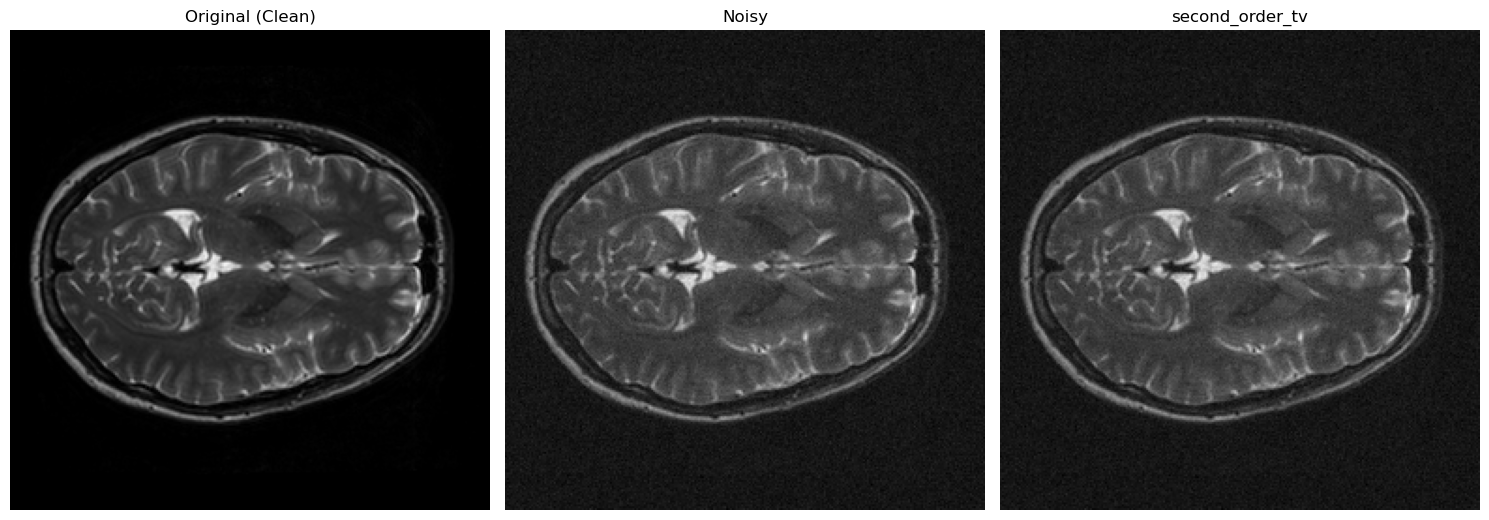

In [ ]:
import matplotlib.pyplot as plt

slice_idx = 5
# Extract precomputed clean, noisy, and WNNM-denoised slices
clean_slice = slices[..., slice_idx]
noisy_slice = noisy_slices[..., slice_idx]
second_order_tv_slice = np.array(denoised_slices)[..., slice_idx]

# Plot all results
titles = ['Original (Clean)', 'Noisy', 'second_order_tv']
images = [clean_slice, noisy_slice, second_order_tv_slice]

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
axs = axs.ravel()

for i, ax in enumerate(axs):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(titles[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

## Review

Strengths of Second-Order TV Denoising

- **Edge Preservation**  
    - Second-order TV (using Laplacian regularization) is better at preserving sharp edges compared to standard TV, which can sometimes over-smooth.  
    - This explains why it slightly outperforms standard TV (33.52 dB vs. 33.47 dB).

- **Smoothness in Homogeneous Regions**  
    - Handles gradual intensity transitions (e.g., soft tissue in MRI/CT) better than first-order TV because it penalizes curvature rather than just gradients.

- **Computational Efficiency**  
    - Unlike NLM (Non-Local Means, 37.32 dB) or BM3D (33.40 dB), second-order TV doesn’t require patch comparisons, making it faster for large images.

---

Weaknesses & Limitations

- **Still Inferior to NLM**  
    - NLM (37.32 dB) is significantly better because it leverages non-local similarities, making it robust against noise while preserving fine textures.  
    - Second-order TV struggles with textured regions because it enforces piecewise smoothness rather than structural similarity.

- **Over-Smoothing in High-Noise Cases**  
    - If noise is strong, second-order TV may blur fine details (e.g., small vessels in MRI) to enforce smoothness.

- **Parameter Sensitivity**  
    - The lambda_tv (regularization strength) must be tuned carefully:  
    - Too low → residual noise remains.  
    - Too high → loss of fine structures.


# Denoising clean image

Use the Prob#1.png image without adding noise as the input of the denoising methods (Total Variation, BM3D, NLM, WNNM) and calculate the PSNR of the input image and output image of the algorithm. By examining the eye and the number,can you tell which method causes less damage to a clean and noise-free image?

## Load

In [ ]:
from PIL import Image
import numpy as np

# Load the image
image_path = "Prob#1.png"
image = Image.open(image_path)
image_array = np.array(image)

## Non-Local Means (NLM)

In [ ]:
from skimage.restoration import denoise_nl_means, estimate_sigma

sigma_est = np.mean(estimate_sigma(image_array, channel_axis=None))
nlm_denoised = denoise_nl_means(
    image_array,
    h=1.15 * sigma_est,
    fast_mode=True,
    patch_size=5,
    patch_distance=6,
    channel_axis=None
)


## BM3D

In [ ]:
from bm3d import bm3d, BM3DProfile

sigma_psd = 0.02
bm3d_denoised = bm3d(image_array, sigma_psd=sigma_psd, profile=BM3DProfile())


## Total Variation (TV)

In [ ]:
from skimage.restoration import denoise_tv_chambolle

tv_denoised = denoise_tv_chambolle(image_array, weight=0.1, channel_axis=None)

## Weighted Nuclear Norm Minimization (WNNM)

In [ ]:
from scipy.linalg import svd

def wnnm(img, patchRadius, delta, c, K, sigma_n,N_threshold):
    # This function applies weighted nuclear norm minimization based denoising to the imput image img
    # Specify the search window
    searchWindowRadius = patchRadius*3

    # Specify the number of iterations for estimating \hat{X}_j
    N_iter = 3

    # Specify the width of padding and pad the noisy image
    pad = searchWindowRadius + patchRadius
    imgPad = np.pad(img, pad_width = pad)
    imgPad = imgPad[..., pad:-pad]

    # Initialize variables to be iterated over
    xhat_iter = img

    for n in range(K):
        # Pad the image for the iteration
        xhat_iter = np.pad(xhat_iter, pad_width = pad)
        xhat_iter = xhat_iter[..., pad:-pad]

        # Regularize the image that is denoised during the iteration
        y_iter = xhat_iter + delta*(imgPad - xhat_iter)

        # Initialize the matrix to keep track of how many times each pixel has been updated
        pixel_contribution_matrix = np.ones_like(imgPad)

        # Identify similar patches and produce the matrix of similar patches
        for j in range(img.shape[0]):
            for i in range(img.shape[1]):
                # Select the central patch
                centerPatch = y_iter[j+searchWindowRadius:j+searchWindowRadius+2*patchRadius,
                                 i+searchWindowRadius:i+searchWindowRadius+2*patchRadius,
                                 :]

                # Initialize the vector of distances between patches
                dists= np.ones(((2*searchWindowRadius+1)**2))
                # Initialize the matrix of patches
                patches = np.zeros(((2*searchWindowRadius+1)**2,(2*patchRadius)**2))
                # Compute distances between patches
                # This is partially vectorized by using indexing to take out patches in a sliding window fashing
                # out of a vertical slice through the search window
                for k in range(2*searchWindowRadius+1):
                    # Take a vertical slice in the search window
                    otherPatch = y_iter[j:j+2*pad,
                                    i+k:i+k+2*patchRadius,
                                    :]

                    # Determine indices corresponding to patches in a window sliding down the search window
                    indexer = np.arange((2*patchRadius)**2)[None, :] + (2*patchRadius)*np.arange(otherPatch.shape[0]-2*patchRadius+1)[:, None]

                    # Set columns to be patches
                    otherPatch = otherPatch.flatten()
                    otherPatch = np.reshape(otherPatch[indexer],(otherPatch[indexer].shape[0],(2*patchRadius)**2))

                    # Compute distance and store the corresponding patches
                    dists[k*(2*searchWindowRadius+1):(k+1)*(2*searchWindowRadius+1)] = (np.sum((centerPatch.reshape(((2*patchRadius)**2))-otherPatch)**2,axis=1)/(2*patchRadius)**2).flatten()
                    patches[k*(2*searchWindowRadius+1):(k+1)*(2*searchWindowRadius+1),:] = otherPatch

                # Select to N_threshold nearest patches and creat a patch matrix
                indcs = np.argsort(dists)
                Yj = (patches[indcs[:N_threshold],:]).transpose()

                # Center the columns
                Yj_means = np.sum(Yj,axis=0)
                Yj_center = Yj - Yj_means

                # First iteration need to estimate singular values of Xj
                U,S,V_T = svd(Yj_center, full_matrices=False)
                sing_val = np.sqrt(np.maximum(S**2-N_threshold*sigma_n**2,0))

                # Calculate the weights and sinfular values of \hat{X}_j iteratively
                for m in range(N_iter):
                    w = c*np.sqrt(N_threshold)/(sing_val+10**(-6))
                    sing_val = np.diag(np.maximum(S-w,0))

                # Compute \hat{X}_j
                Xj_hat_center = U@np.diag(np.maximum(S-w,0))@V_T
                Xj_hat = Xj_hat_center + Yj_means

                # Add the estimate of denoised central patch (first column of \hat{X}_j) to the esmated denoised image clipping it to between 0 and 1
                xhat_iter[j+searchWindowRadius:j+searchWindowRadius+2*patchRadius,
                                 i+searchWindowRadius:i+searchWindowRadius+2*patchRadius,
                                 :] = xhat_iter[j+searchWindowRadius:j+searchWindowRadius+2*patchRadius,
                                 i+searchWindowRadius:i+searchWindowRadius+2*patchRadius,
                                 :] + np.clip(Xj_hat[:,0].reshape((2*patchRadius,2*patchRadius,1)),0,1)

                # Keep track of how many times each pixel has been added to
                pixel_contribution_matrix[j+searchWindowRadius:j+searchWindowRadius+2*patchRadius,
                                 i+searchWindowRadius:i+searchWindowRadius+2*patchRadius,
                                 :] = pixel_contribution_matrix[j+searchWindowRadius:j+searchWindowRadius+2*patchRadius,
                                 i+searchWindowRadius:i+searchWindowRadius+2*patchRadius,
                                 :] + np.ones_like(pixel_contribution_matrix[j+searchWindowRadius:j+searchWindowRadius+2*patchRadius,
                                 i+searchWindowRadius:i+searchWindowRadius+2*patchRadius,:])

        # Remove the padding and average out contributions to pixels from different patches
        xhat_iter = xhat_iter[pad:-pad,
                    pad:-pad,
                   :]/pixel_contribution_matrix[pad:-pad,
                    pad:-pad,
                   :]

    # Produce the final output
    out = xhat_iter
    return out

# Hyperparameters for WNNM
patchRadius = 2           # patch size = 4x4
delta = 0.1
c = 2                     # tuning parameter
K = 1                     # number of iterations (can go higher for more refinement)
sigma_n = 0.02            # noise std dev (same as used for pollution)
N_threshold = 16          # number of similar patches

# Split the image into 16 slices of size 256x256
slices = []
slice_size = 256
for i in range(0, 1024, slice_size):
    for j in range(0, 1024, slice_size):
        slices.append(image_array[i:i+slice_size, j:j+slice_size])

# Apply WNNM to each slice
denoised_slices = []
for idx, slice_input in enumerate(slices):
    print(f"Processing slice {idx + 1} with WNNM...")
    # WNNM expects 3D input (H, W, 1), so we expand dims
    denoised = wnnm(slice_input[..., np.newaxis], patchRadius, delta, c, K, sigma_n, N_threshold)
    # Remove the singleton dimension and store the result
    denoised_slices.append(np.squeeze(denoised))

# Combine the denoised slices back into a single 1024x1024 image
wnnm_denoised = np.zeros_like(image)
slice_idx = 0
for i in range(0, 1024, slice_size):
    for j in range(0, 1024, slice_size):
        wnnm_denoised[i:i+slice_size, j:j+slice_size] = denoised_slices[slice_idx]
        slice_idx += 1


Processing slice 1 with WNNM...
Processing slice 2 with WNNM...
Processing slice 3 with WNNM...
Processing slice 4 with WNNM...
Processing slice 5 with WNNM...
Processing slice 6 with WNNM...
Processing slice 7 with WNNM...
Processing slice 8 with WNNM...
Processing slice 9 with WNNM...
Processing slice 10 with WNNM...
Processing slice 11 with WNNM...
Processing slice 12 with WNNM...
Processing slice 13 with WNNM...
Processing slice 14 with WNNM...
Processing slice 15 with WNNM...
Processing slice 16 with WNNM...


## PSNR & Plot & Deduction

In [ ]:
def compute_psnr(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = np.max(original)
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

In [ ]:
# Compute PSNR
psnr_wnnm = compute_psnr(image_array, wnnm_denoised)
psnr_nlm = compute_psnr(image_array, nlm_denoised)
psnr_bm3d = compute_psnr(image_array, bm3d_denoised)
psnr_tv = compute_psnr(image_array, tv_denoised)
print(f"WNNM PSNR: {psnr_wnnm:.2f} dB")
print(f"NLM PSNR: {psnr_nlm:.2f} dB")
print(f"BM3D PSNR: {psnr_bm3d:.2f} dB")
print(f"TV PSNR: {psnr_tv:.2f} dB")

WNNM PSNR: 30.66 dB
NLM PSNR: 8.06 dB
BM3D PSNR: 111.51 dB
TV PSNR: 8.06 dB


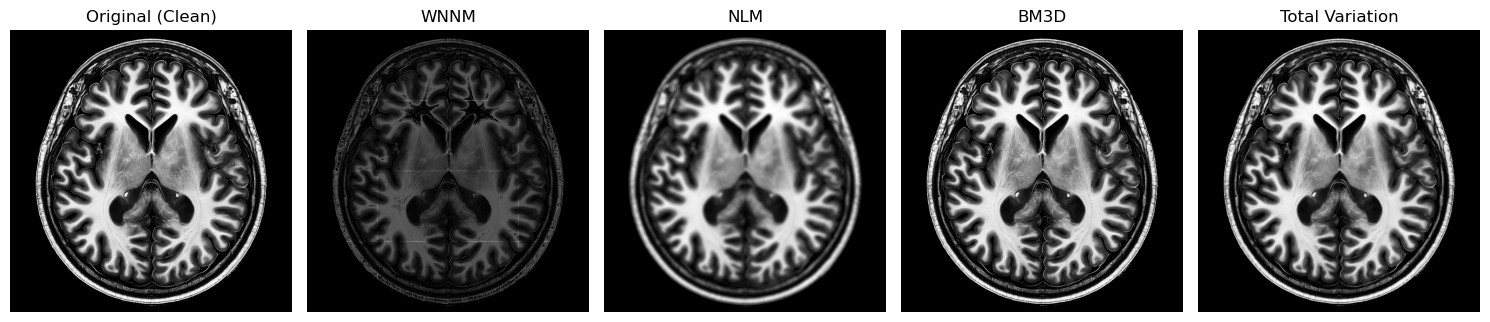

In [ ]:
import matplotlib.pyplot as plt

# Plot all results
titles = ['Original (Clean)', 'WNNM', 'NLM', 'BM3D', 'Total Variation']
images = [image_array, wnnm_denoised, nlm_denoised, bm3d_denoised, tv_denoised]

fig, axs = plt.subplots(1, 5, figsize=(15, 10))
axs = axs.ravel()

for i, ax in enumerate(axs):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(titles[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

*NLM* and *TV* `damaged` the clean image drastically (or their parameters were set extremely aggressively). *WNNM* only mildly changed it. *BM3D*, on the other hand, supposedly `left it near-perfect`